**Name**: Jingwei Kang <br>
**Date**: November 2018 <br>
**Reference**: "Position-dependent diffusion coefficients and free energies from Bayesian analysis of equilibrium and replica molecular dynamics simulations (Hummer 2005)"

### **1. Purpose**: <br>
The goal of this exercise is to determine diffusion coefficients and free energies by using a global Bayesian analysis on simulation data. Using Bayes' formula, we can relate a likelihood function (the probability of observing the motions in a simulation run given a set of parameters) to the probability that a set of parameters are correct.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import math
import numba
from scipy.linalg import expm
%matplotlib inline

### **2. Toy Model**: <br>
As an example, we consider 1D diffusion on the free energy surface: <br>
$\beta F(\psi) = -cos(2\psi) + C$, where $\beta^{-1} = k_{B}T$ and $C$ is a constant. <br>
$D(\psi) = (2 + sin\psi)D_{0}$, where $D_{0}=0.1 rad^{2}ps^{-1}$ <br>
$\psi(t+\Delta t)=\psi(t) + (D'[\psi(t)]-\beta D[\psi(t)]F'[\psi(t)])\Delta t + g_{t} (2D[\psi(t)]\Delta t)^{1/2}$, where $g_{t}$ is an uncorrelated Gaussian random variables N(0,1) and primes denote first derivatives with respect to psi. We take $\Delta t=0.001ps$ for $100ns$. <br>
$ F'(\psi) = \beta^{-1} 2sin(2\psi)$ <br>
$ D'(\psi) = D_{0}cos\psi$ 

In [2]:
T = 300 # Kelvin
k_b = 1.3806*10**-23 # J/K
Beta = 1/(k_b * T)
dt = 10**-3 # time step of simulation in ps
ns = 100 # time for simulation in ns
t = np.arange(0, ns*10**3, dt)
D_0 = 0.1 # rad^2 ps^-1

@numba.jit(nopython=True)
def F(psi):
    return -1/Beta * np.cos(2*psi)

@numba.jit(nopython=True)
def D(psi):
    return (2 + np.sin(psi))*D_0

@numba.jit(nopython=True)
def F_prime(psi):
    return 1/Beta * 2 * np.sin(2 * psi)

@numba.jit(nopython=True)
def D_prime(psi):
    return D_0 * np.cos(psi)

In [3]:
@numba.jit(nopython=True)
def run_simulations(F, F_prime, D, D_prime, dt=10**-3, ns=100):
    """
    Parameters
    ----------
    F: function handle for the free energy function
    F_prime: function handle for the first derivative of the free energy function
    D: function handle for the diffusion function
    D_prime: function handle for the first derivative of the free energy
    dt: time step of simulation in picoseconds
    ns: number of nanoseconds we simulate for

    Returns
    -------
    psi: np.array of the angles we simulate
    """
    T = 300 # Kelvin
    k_b = 1.3806*10**-23 # J/K
    Beta = 1/(k_b * T)
    t = np.arange(0, ns*10**3, dt)
    psi = np.zeros_like(t)
    psi[0] = 0
    for i in np.arange(1, len(t)):
        if (i%(len(t)/10) == 0):
            print('Finished ', i, ' of ', len(t), ' iterations...')
        psi[i] = psi[i-1] + (D_prime(psi[i-1]) - Beta*D(psi[i-1])*F_prime(psi[i-1]))*dt + np.random.randn()*(2*D(psi[i-1])*dt)**0.5
    return psi

In [4]:
psi = run_simulations(F, F_prime, D, D_prime, dt, ns)

Finished  10000000  of  100000000  iterations...
Finished  20000000  of  100000000  iterations...
Finished  30000000  of  100000000  iterations...
Finished  40000000  of  100000000  iterations...
Finished  50000000  of  100000000  iterations...
Finished  60000000  of  100000000  iterations...
Finished  70000000  of  100000000  iterations...
Finished  80000000  of  100000000  iterations...
Finished  90000000  of  100000000  iterations...


### **3. Transition Matrix**: <br>
For constructing the likelihood function, we extract $\psi$ at every 0.5ps and use it to determine the number of transitions between states. We examine only $\psi$ in $[-\pi, \pi]$. Since the free energy landscape is periodic, we simply shift any data out of this range.

In [5]:
@numba.jit(nopython=True)
def periodize_simulations(psi, dt, tau=0.5):
    """
    Parameters
    ----------
    psi: np.array of angles from our simulations
    tau: time step of transitions in picoseconds
    dt: time step of simulation in picoseconds
    
    Returns
    -------
    saved_psi: np.array of periodized angles sampled at the transition time steps of psi
    """
    saved_psi = psi[np.arange(0, len(psi), int(tau/dt))]
    saved_psi[saved_psi > np.pi] = np.array([psi - np.rint(psi/(2*np.pi))*2*np.pi for psi in saved_psi[saved_psi > np.pi]])
    saved_psi[saved_psi < -np.pi] = np.array([psi - np.rint(psi/(2*np.pi))*2*np.pi for psi in saved_psi[saved_psi < -np.pi]])
    return saved_psi

In [6]:
tau = 0.5 #ps
saved_psi = periodize_simulations(psi, dt, tau)

We discretize the reaction coordinate $\psi$ into cells of size $\Delta \psi = \frac{2\pi}{n}$, where $n = 12, 24, 36, 48$. We use $n=24$ below.

In [7]:
@numba.jit(nopython=True)
def calc_transition_matrix(saved_psi, n):
    """
    Parameters
    ----------
    saved_psi: np.array of angles adjusted for periodicity
    n: number of discretized states between -pi and pi
    
    Returns
    -------
    Nij: 2D np.array representing transition counts where i and j are the end and start state, respectively
    """
    dpsi = 2*np.pi/n
    Nij = np.zeros((n, n)) # Let rows be i and cols be j
    for k in np.arange(0, len(saved_psi) - 1):
        j = saved_psi[k]
        nj = int(np.floor((j-(-np.pi))/dpsi)) # Cell number that j is in
        offset = (nj*dpsi + dpsi/2) - (j-(-np.pi))# offset to 
        i = saved_psi[k + 1] + offset
        if i > np.pi:
            i -= 2*np.pi
        elif i < -np.pi:
            i += 2*np.pi
        ni = int(np.floor((i-(-np.pi))/dpsi)) # Cell number that i is in
        Nij[ni][nj] += 1
    return Nij

In [8]:
n = 24
dpsi = 2*np.pi/n
Nij = calc_transition_matrix(saved_psi, n)

Below is a color map of the transition matrix, calculated from data with periodic adjustment. Note that the column represents the cell number of state j and the row represents the cell number of state i. As expected, we see higher density of transitions in adjacent states (i.e. the diagonal from (0, 0) to (23, 23)). Furthermore, we see greatest density near the free energy minimums (cells 0, 12, and 23). Note that densities around (0, 24) and (24, 0) are off the primary diagonal and represent the wrap-around from our periodic adjustment. 

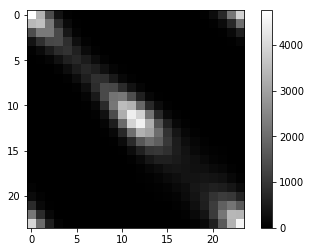

In [9]:
Nij_map = plt.imshow(Nij, cmap='gray')
plt.colorbar(Nij_map) # visualize transition matrix

The reaction coordinates and their corresponding free energies are then plotted as a time series. We notice lines spanning across periods, such as from a reaction coordinate of $\frac{2\pi}{3}$ to $\frac{-2\pi}{3}$. This is due to our periodic adjustment. In reality, the line would have spanned $\frac{2\pi}{3}$ to $\frac{4\pi}{3}$, or more arbitarily $\frac{n\pi}{3}$ to $\frac{(n+2)\pi}{3}$ for some n.

Text(0.5, 0, '$\\psi$')

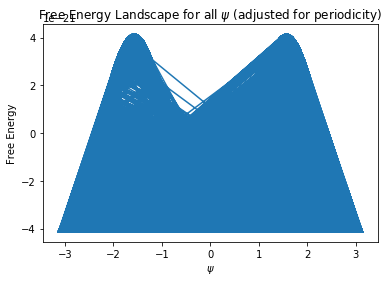

In [10]:
plt.plot(saved_psi, F(saved_psi))
plt.title('Free Energy Landscape for all $\psi$ (adjusted for periodicity)')
plt.ylabel('Free Energy')
plt.xlabel('$\psi$')

### 3. Rate Parameters: Random Walk <br>
The goal of this sampling process is to more gradually change the rate parameter matrix so that we can observe a smoother change in the log-likelihood matrix. Furthermore, since we don't know the correct interval to sample **R** from, we will implement a random walk. Additionally, we will determine the probability of being in a state by directly using simulation data (as opposed to sampling free energies from a uniform distribution). 

In these simulations, we will explore a number of methods. 

For state probabilities, we can:
1. Use data from our simulation.
2. Start with $F_{i}=0$ and random walk a random index, and find $P_{i}$ given that $F_{i} = -k_{b}Tln(P_{i}/\Delta\psi)$. Thus, $P_{i} = \Delta\psi e^{-\frac{F_{i}}{k_{b}T}}$.
3. Perform the same random walk procedure as in 2. but use the Nth probability to norm the rest (such that they sum to 1.

For rate parameters, we can:
1. First begin with **R** full of zeros and per iteration, randomly select an index in the bottom left triangle of our matrix representing a transition to an adjacent state and perform a random walk on it.
2. Perform a random walk on any index in the bottom left triangle.
3. Perform multiple random walks per iteration.

Per iteration, we will then update the rest of the matrix according to the law of detailed balance and calculate the log-likelihood.

In our example, the log-likelihood function is defined as: <br>
$ln\ L =\sum_{i=1}^{n}\sum_{j=1}^{n}\ N_{ij}\ ln(e^{t\mathbf{R}})_{ij}$

From the Metropolis criterion, we accept the new simulation only if the log-likelihood increases, otherwise we accept with probability $exp(-\Delta)$ where $\Delta$ is the decrease in log-likelihood.

In [11]:
@numba.jit(nopython=True)
def calc_state_prob(n, P_old):
    """
    Parameters
    ----------
    n: number of discretized states between -pi and pi
    P_old: np.array of state probabilities from previous iteration
    
    Returns
    -------
    P: np.array of state probabilities from saved_psi
    """
    dp = 10
    dpsi = 2*np.pi/n
    if np.sum(P_old) == 0:
        P = dpsi*np.exp(np.zeros(n))
        P = P/np.sum(P) # normalize
    else:
        F = -np.log(P_old/dpsi+1e-10) # I removed Beta here so we see effects from RW
        randi = np.random.randint(low=0, high=n)
        F[randi] += dp*(np.random.random()-0.5)
        P = dpsi*np.exp(-F) # I removed Beta here
        P = P/np.sum(P) # normalize
    return P

@numba.jit(nopython=True)
def calc_state_prob_norm(n, P_old):
    """
    Parameters
    ----------
    n: number of discretized states between -pi and pi
    P_old: np.array of state probabilities from previous iteration
    
    Returns
    -------
    P: np.array of state probabilities from saved_psi
    """
    dp = 10
    dpsi = 2*np.pi/n
    if np.sum(P_old) == 0:
        P = dpsi*np.exp(np.zeros(n))
        P = P/np.sum(P) # normalize
    else:
        F = -np.log(P_old/dpsi+1e-10) # I removed Beta here so we see effects from RW
        randi = np.random.randint(low=0, high=n-1)
        F[randi] += dp*(np.random.random()-0.5)
        P = dpsi*np.exp(-F) # I removed Beta here so we see effects from RW
        Psum = np.sum(P[:-1])
        P[-1] = 1-Psum # normalize
    return P

@numba.jit(nopython=True)
def calc_state_prob_from_data(n, P_old, saved_psi=saved_psi):
    """
    Parameters
    ----------
    saved_psi: np.array of angles adjusted for periodicity
    n: number of discretized states between -pi and pi
    P_old: np.array of state probabilities from previous iteration
    
    Returns
    -------
    P: np.array of state probabilities from saved_psi
    """
    if np.sum(P_old) == 0:
        P = np.zeros(n)
        dpsi = 2*np.pi/n
        for psi in saved_psi:
            npsi = int(np.floor((psi-(-np.pi))/dpsi)) # cell that sample is in
            P[npsi] += 1
        P /= len(saved_psi) # normalize
    else: # We don't want to recalculate since P from state data is constant
        P = P_old
    return P

@numba.jit(nopython=True)
def calc_param_matrix(n, R_old, P, dr=0.05): # Be sure to check calc_log_likelihood
    """
    Parameters
    ----------
    n: number of discretized states between -pi and pi
    R_old: 2D np.array of the previous rate matrix
    P: np.array of state probabilities from saved_psi
    dr: step size for random walk
    
    Returns
    R: 2D np.array of the new rate matrix
    -------
    """
    # Need to sample only tridiagonal/corners
    # Rij = state j-> state i
    R = R_old # Let rows be i and cols be j, [0,1)
    randi = np.random.randint(low=0, high=n)
    if randi == 0: # for bottom corner 
        randi += n-1
        randj = 0
    else:
        randj = randi - 1
    R[randi][randj] += max(dr*(np.random.random()-0.5), 0) # Get issues if it's negative
    R[randj, randi] = R[randi, randj] * P[randj]/P[randi] # Corresponding value on upper right triangle
    R[randi, randi] = -np.sum(R[np.arange(n)!=randi, randi]) # Diagonal value to be updated
    R[randj, randj] = -np.sum(R[np.arange(n)!=randj, randj]) # Diagonal value to be updated
    return R

# @numba.jit(nopython=True) #tril_indices not supported by numba
def calc_param_matrix_all(n, R_old, P, dr=0.05): # Be sure to check calc_log_likelihood
    """
    Parameters
    ----------
    n: number of discretized states between -pi and pi
    R_old: 2D np.array of the previous rate matrix
    P: np.array of state probabilities from saved_psi
    dr: step size for random walk
    
    Returns
    R: 2D np.array of the new rate matrix
    -------
    """
    # Need to sample everything in lower triangle
    # Rij = state j-> state i
    R = R_old # Let rows be i and cols be j, [0,1)
    tril_indices = np.tril_indices(n=n, k=-1) # k is an offset so this ignores main diagonal
    tril_index = np.random.randint(low=0, high=len(tril_indices[0]))
    randi = tril_indices[0][tril_index]
    randj = tril_indices[1][tril_index]
    R[randi][randj] += max(dr*(np.random.random()-0.5), 0) # Get issues if it's negative
    R[randj, randi] = R[randi, randj] * P[randj]/P[randi] # Corresponding value on upper right triangle
    R[randi, randi] = -np.sum(R[np.arange(n)!=randi, randi]) # Diagonal value to be updated
    R[randj, randj] = -np.sum(R[np.arange(n)!=randj, randj]) # Diagonal value to be updated
    return R

def calc_param_matrix_all_mult(n, R_old, P, dr=0.05): # Be sure to check calc_log_likelihood
    """
    Parameters
    ----------
    n: number of discretized states between -pi and pi
    R_old: 2D np.array of the previous rate matrix
    P: np.array of state probabilities from saved_psi
    dr: step size for random walk
    
    Returns
    R: 2D np.array of the new rate matrix
    -------
    """
    # Need to sample everything in lower triangle
    # Rij = state j-> state i
    R = R_old # Let rows be i and cols be j, [0,1)
    tril_indices = np.tril_indices(n=n, k=-1) # k is an offset so this ignores main diagonal
    for _ in range(5):# we want to random walk 5 indices per iteration
        tril_index = np.random.randint(low=0, high=len(tril_indices[0]))
        randi = tril_indices[0][tril_index]
        randj = tril_indices[1][tril_index]
        R[randi][randj] += max(dr*(np.random.random()-0.5), 0) # Get issues if it's negative
        R[randj, randi] = R[randi, randj] * P[randj]/P[randi] # Corresponding value on upper right triangle
        R[randi, randi] = -np.sum(R[np.arange(n)!=randi, randi]) # Diagonal value to be updated
        R[randj, randj] = -np.sum(R[np.arange(n)!=randj, randj]) # Diagonal value to be updated
    return R

# @numba.jit()
def calc_log_likelihood_from_R(n, Nij, R, tau=0.5):
    """
    Parameters
    ----------
    n: number of discretized states between -pi and pi
    Nij: 2D np.array representing transition counts where i and j are the end and start state, respectively
    tau: time step of transitions in picoseconds
    R: 2D np.array of sampled rate parameters Rij where state j transitions to state i
    
    Returns
    -------
    log_likelihood: log_likelihood corresponding to transition matrix, rate matrix, and probabilities
    """
    propagator = expm(tau*R)
    log_likelihood = np.float64(0.0)  
    tiny = 1e-10
    b = Nij*np.log(propagator.clip(tiny))
    val = np.sum(b)
    log_likelihood += val
    return log_likelihood
    
# @numba.jit()
def calc_log_likelihood(n, Nij, R_old, P_old, P_method, rw_method=calc_param_matrix_all, dr=0.05, tau=0.5):
    """
    Parameters
    ----------
    n: number of discretized states between -pi and pi
    Nij: 2D np.array representing transition counts where i and j are the end and start state, respectively
    R_old: 2D np.array of the previous rate matrix
    P_old: np.array of previous state probabilities
    P_method: method to update state probabilities
    rw_method: method to update rate parameter matrix - by default we random walk all indices in matrix
    dr: step size for random walk
    tau: time step of transitions in picoseconds
    
    Returns
    -------
    R: 2D np.array of sampled rate parameters Rij where state j transitions to state i
    P: np.array of state probabilities
    log_likelihood: log_likelihood corresponding to transition matrix, rate matrix, and probabilities
    """
    P = P_method(n, P_old)
    R = rw_method(n, R_old, P, dr)
    log_likelihood = calc_log_likelihood_from_R(n, Nij, R, tau)
    return R, P, log_likelihood

We take a quick look at the probabilities from the simulation data. Intuitively this makes sense - we see highest probability corresponding to the states where we saw the lowest free energy in our diagrams earlier. 

Text(0, 0.5, 'Probability')

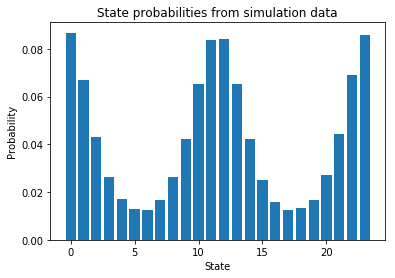

In [12]:
P = calc_state_prob_from_data(n, np.zeros(n),saved_psi)
plt.bar(np.arange(n), P)
plt.title('State probabilities from simulation data')
plt.xlabel('State')
plt.ylabel('Probability')

We need to create many initial rate matrices before we run Metropolis Monte Carlo. The following function creates a matrix with values filled at indices corresponding to adjacent state transitions.

In [13]:
def create_init(Rij, P):
    """
    Parameters
    ----------
    Rij: initial value on indices corresponding to adjacent transition states
    P: np.array of sampled probabilities
    
    Returns
    -------
    R_init: initial rate matrix
    log_likelihood_init: corresponding initial rate matrix
    """
    n = len(P)
    R_init = np.zeros(shape=(n,n))
    for i in range(n-1):
        R_init[i+1][i] = Rij
    R_init[n-1][0] = Rij 
    for j in np.arange(n):
        for i in np.arange(n):
            if i == j:
                R_init[i, j] = -np.sum(R_init[np.arange(n)!=i, i])
            elif i < j:
                R_init[i, j] = R_init[j, i] * P[i]/P[j]
    log_likelihood_init = calc_log_likelihood_from_R(n, Nij, R_init, tau)
    return R_init, log_likelihood_init
    

In [14]:
# @numba.jit()
def MetropolisMC(Rij, Nij, P_method, rw_method=calc_param_matrix_all, dr=0.05, iterations=10**6, burnout=0.5*10**6):
    """
    Parameters
    ----------
    Rij: initial value on indices corresponding to adjacent transition states
    Nij: 2D np.array representing transition counts where i and j are the end and start state, respectively
    P_method: method to update state probabilities
    rw_method: random walk method for rate matrix updates
    dr: step size for random walk
    iterations: number of iterations
    burnout: number of iterations before we start recording the rate matrix
    
    Returns
    -------
    R_after_burnout: average rate matrix after a burnout period
    P_after_burnout: average state probabilities after a burnout period
    log_likelihood_array: np.array of log_likelihoods
    """
    P_init = P_method(n, np.zeros(n))
    R_init, log_likelihood_init = create_init(Rij, P_init)
    update = 100
    accept = 0
    R_old, P_old, log_likelihood_old = R_init, P_init, log_likelihood_init
    log_likelihood_array = np.zeros(iterations)
    R_after_burnout = np.zeros_like(R_init)
    P_after_burnout = np.zeros_like(P_init)
    count = 1
    for i in np.arange(iterations):
        if i > 0:
            if (i % update == 0 ):
                dr *= np.exp ( 0.1 * ( float(accept) / update - 0.3 ) )
                accept = 0
        if (i%(iterations/10) == 0):
            print('Finished ', i, ' of ', iterations, ' iterations...')
        log_likelihood_array[i] = log_likelihood_old
        R_new, P_new, log_likelihood_new = calc_log_likelihood(n, Nij, R_old, P_old, P_method, rw_method, dr, tau)
        if np.exp(log_likelihood_new - log_likelihood_old) > np.random.random():##
            R_old, P_new, log_likelihood_old = R_new, P_new, log_likelihood_new
            accept += 1
        if i>= burnout:
           # Save memory by updating array instead of appending
            R_after_burnout = R_after_burnout * (count - 1)/count + R_old/count
            P_after_burnout = P_after_burnout * (count - 1)/count + P_old/count
            count += 1 
    return R_after_burnout, P_after_burnout, log_likelihood_array

In [15]:
def plot_log_likelihood(log_likelihood_array):
    """
    Parameters
    ----------
    log_likelihood_array: np.array of log_likelihoods
    """
    fig, ax = plt.subplots()
    iterations = len(log_likelihood_array)
    ax.plot(np.arange(0, iterations, 100), log_likelihood_array[np.arange(0, iterations, 100)])
    ax.set_title('Log-likelihood vs. iterations, random walk')
    ax.set_ylabel('Log-likelihood')
    ax.set_xlabel('Iterations')

def plot_R(R, Rmax):
    """
    Parameters
    ----------
    R: 2D np.array rate parameter to visualize
    Rmax: maximum rate coefficient to visualize
    """
    fig, ax = plt.subplots()
    ax = plt.imshow(R, cmap='gray', norm=colors.BoundaryNorm(boundaries=np.linspace(0, Rmax, 100), ncolors=256)) 
    plt.colorbar(mappable=ax) # visualize rate parameter matrix

def plot_P(P):
    """
    Parameters
    ----------
    P: np.array of state probabilities
    """
    fig, ax = plt.subplots()
    n = len(P)
    ax = plt.bar(np.arange(n), P)
    plt.title('State probabilities')
    plt.xlabel('State')
    plt.ylabel('Probability')

### 4. Free Energy and Diffusion from Rate Parameters

$F({\psi_{i}}) = -k_{b}Tln(P_{i}/\Delta\psi)$ <br>
$D_{i+1/2} = \Delta \psi^{2} R_{i+1, i} (\frac{P_{i}}{P_{i+1}})^{1/2}$ 

In [16]:
@numba.jit(nopython=True)
def calc_D(n, R, P, dpsi):
    """
    Parameters
    ----------
    n: number of discretized states between -pi and pi
    R: 2D np.array of the rate matrix
    P: np.array of sampled probabilities
    dpsi: step size for random walk
    
    Returns
    -------
    D: np.array of diffusion coefficients
    D_index: np.array of corresponding indices frop -pi to pi
    """
    # Diffusion, unadjusted
    D = np.zeros(n-1)
    D_index = np.arange(0.5, n-0.5)*dpsi - np.pi
    for i in np.arange(0, n-1):
        D[i] = dpsi**2 * R[i+1, i] * (P[i] / P[i+1])**0.5
    return D, D_index

@numba.jit(nopython=True)
def calc_F(P, dpsi):
    """
    Parameters
    ----------
    P: np.array of sampled probabilities
    dpsi: step size for random walk
    
    Returns
    -------
    F: np.array of free energy
    F_index: np.array of corresponding indices frop -pi to pi
    """
    F_index = np.arange(0, n)*dpsi - np.pi
    F = -np.log(P/dpsi)
    return F, F_index

def plot_F_and_D(n, R, P, dpsi):
    """
    Parameters
    ----------
    n: number of discretized states between -pi and pi
    R: 2D np.array of the rate matrix
    P: np.array of sampled probabilities
    dpsi: step size for random walk
    """
    F, F_index = calc_F(P, dpsi)
    D, D_index = calc_D(n, R, P, dpsi)
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8,6))
    ax1.set_title('$R_{ij, initial} = 0$')
    ax1.plot(F_index, F)
    ax1.set_ylabel('$F(\psi)/k_BT$')
    ax2.scatter(D_index, D)
    ax2.plot(D_index, 0.1*(2 + np.sin(D_index)), 'r-')
    ax2.set_ylabel('$D\ (rad^2/ps)$')
    ax2.set_xlabel('$\psi$')
    ax2.legend(['Hummer 2015', 'Random walk'])
    plt.subplots_adjust(hspace = .001)

In [17]:
def plot_all(R, log_likelihood_array, Rmax, n, P, dpsi):
    """
    Parameters
    ----------
    R: 2D np.array rate parameter to visualize
    log_likelihood_array: np.array of log likelihoods
    Rmax: maximum rate coefficient to visualize
    n: number of discretized states between -pi and pi
    P: np.array of sampled probabilities
    dpsi: step size for random walk
    """
    plot_log_likelihood(log_likelihood_array)
    plot_P(P)
    plot_R(R, Rmax)
    plot_F_and_D(n, R, P, dpsi)

### 5. Summary of important methods for additional testing
1. ** Prerequisites: ** <br>
These should already have been run earlier in the notebook to generate the invariant transition matrix and probabilities. For additional testing, start from 2.
    * calc_transition_matrix()
    * calc_state_prob_from_data()
2. **Metropolis Monte Carlo simulations: ** <br>
    * MetropolisMC():
3. **Visualization: ** <br>
The specific visuals of interest are log likelihood, the rate parameter matrix, and the calculated coefficients.
    * plot_all()
    
Below is an example that can be copy-pasted and modified:

Finished  0  of  10000  iterations...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp


Finished  1000  of  10000  iterations...
Finished  2000  of  10000  iterations...
Finished  3000  of  10000  iterations...
Finished  4000  of  10000  iterations...
Finished  5000  of  10000  iterations...
Finished  6000  of  10000  iterations...
Finished  7000  of  10000  iterations...
Finished  8000  of  10000  iterations...
Finished  9000  of  10000  iterations...


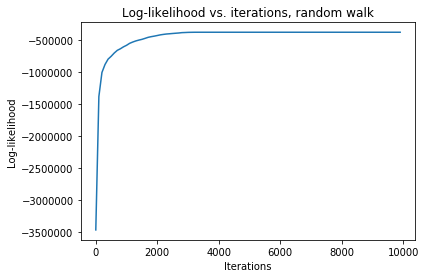

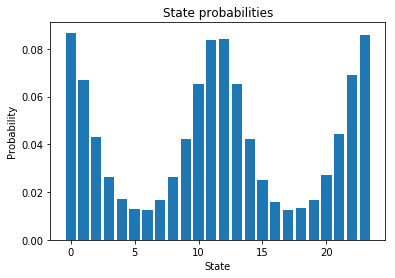

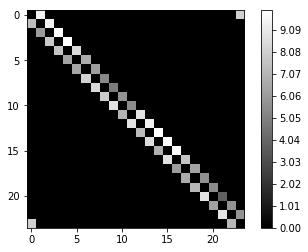

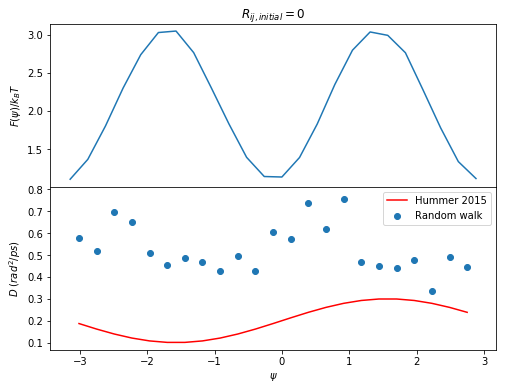

In [18]:
iterations=10**4
burnout=0.5*10**4
R, P, log_likelihood_array = MetropolisMC(Rij=0, Nij=Nij, P_method=calc_state_prob_from_data, rw_method=calc_param_matrix, dr=0.05, iterations=iterations, burnout=burnout)
plot_all(R, log_likelihood_array, 10, n, P, dpsi)

### 6. Calculating rate parameters from Hummer

Since $D_{i+1/2} = \Delta \psi^{2} R_{i+1, i} (\frac{P_{i}}{P_{i+1}})^{1/2}$, we calculate the diffusion coefficients given in Hummer at the values corresponding to our calculations. We then back calculate the rate parameters.

In [19]:
D_index = np.arange(0, n)*dpsi - np.pi
D_hummer = 0.1*(2 + np.sin(D_index))
D_adjusted = np.zeros(D_hummer.size-1)
rates = np.zeros_like(D_adjusted)
for i in range(len(D_adjusted)):
    D_adjusted[i] = np.mean([D_hummer[i], D_hummer[i+1]])
    rates[i] = D_adjusted[i]*(P[i+1]/P[i])**0.5/dpsi**2
rates

array([2.39624479, 1.90076636, 1.58894048, 1.4228892 , 1.36803991,
       1.46949984, 1.70922173, 1.99207642, 2.24253162, 2.5350876 ,
       2.68084193, 2.73819017, 2.73409975, 2.78973649, 2.93070093,
       3.24785153, 3.77563689, 4.44953357, 4.87717877, 5.4294063 ,
       5.21485055, 4.7347321 , 3.87851168])

Thus, lets initiate our rate matrix for simulations with $Rij=3$.

### **7. Random walk with different initial matrices** 
#### We look at the rate parameters, diffusion, and free energy where we initialize the rate parameters to be 0, 1, 10, and 100 allowing random walks **only on indices representing adjacent state transitions**.

#### a. $R_{ij} = 0$
Random walk only on adjacent state transition indices.

Finished  0  of  10000  iterations...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp


Finished  1000  of  10000  iterations...
Finished  2000  of  10000  iterations...
Finished  3000  of  10000  iterations...
Finished  4000  of  10000  iterations...
Finished  5000  of  10000  iterations...
Finished  6000  of  10000  iterations...
Finished  7000  of  10000  iterations...
Finished  8000  of  10000  iterations...
Finished  9000  of  10000  iterations...


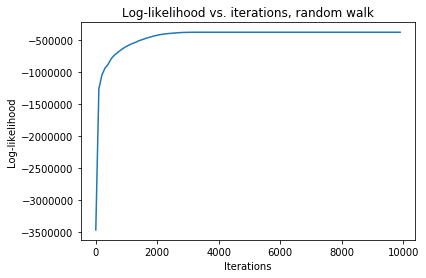

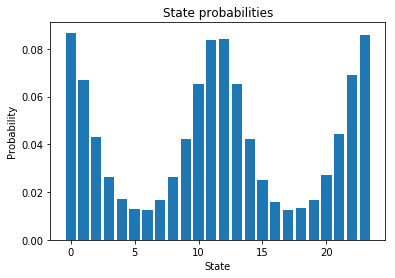

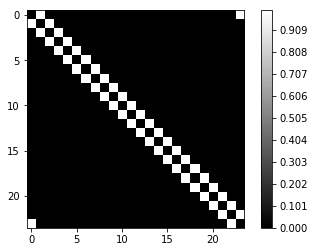

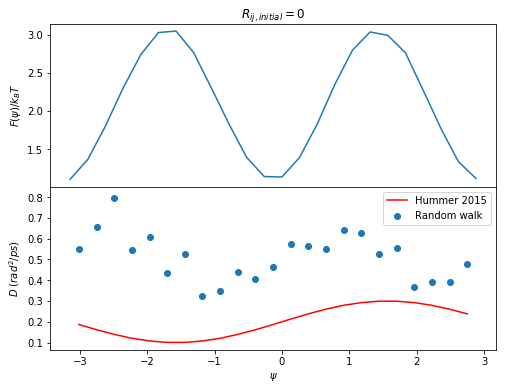

In [20]:
R, P, log_likelihood_array = MetropolisMC(Rij=0, Nij=Nij, P_method=calc_state_prob_from_data, rw_method=calc_param_matrix, dr=0.05, iterations=iterations, burnout=burnout)
plot_all(R, log_likelihood_array, 1, n, P, dpsi)

#### b. $R_{ij} = 1$
Random walk only on adjacent state transition indices.

Finished  0  of  10000  iterations...
Finished  1000  of  10000  iterations...
Finished  2000  of  10000  iterations...
Finished  3000  of  10000  iterations...
Finished  4000  of  10000  iterations...
Finished  5000  of  10000  iterations...
Finished  6000  of  10000  iterations...
Finished  7000  of  10000  iterations...
Finished  8000  of  10000  iterations...
Finished  9000  of  10000  iterations...


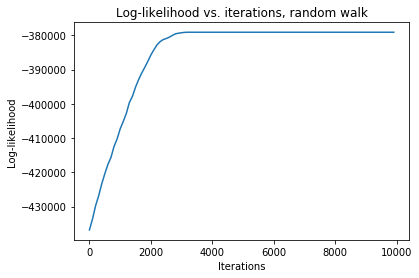

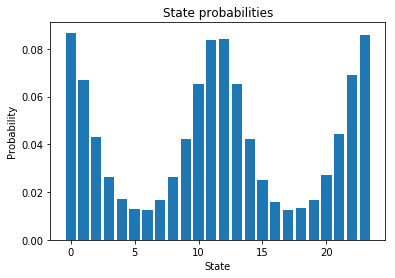

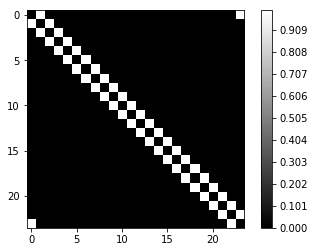

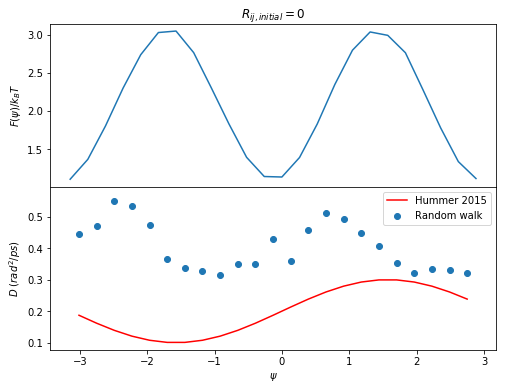

In [21]:
R, P, log_likelihood_array = MetropolisMC(Rij=1, Nij=Nij, P_method=calc_state_prob_from_data, rw_method=calc_param_matrix, dr=0.05, iterations=iterations, burnout=burnout)
plot_all(R, log_likelihood_array, 1, n, P, dpsi)

#### c. $R_{ij} = 10$
Random walk only on adjacent state transition indices.

Finished  0  of  10000  iterations...
Finished  1000  of  10000  iterations...
Finished  2000  of  10000  iterations...
Finished  3000  of  10000  iterations...
Finished  4000  of  10000  iterations...
Finished  5000  of  10000  iterations...
Finished  6000  of  10000  iterations...
Finished  7000  of  10000  iterations...
Finished  8000  of  10000  iterations...
Finished  9000  of  10000  iterations...


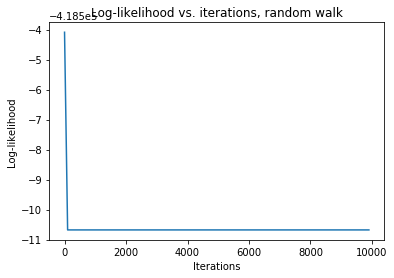

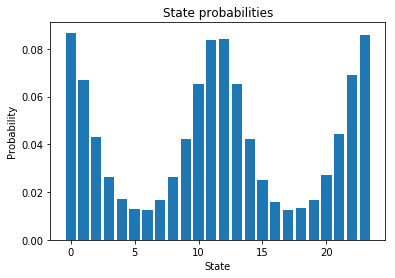

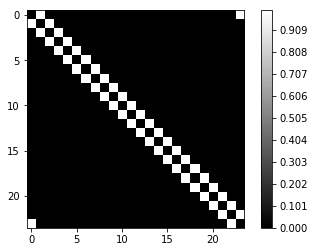

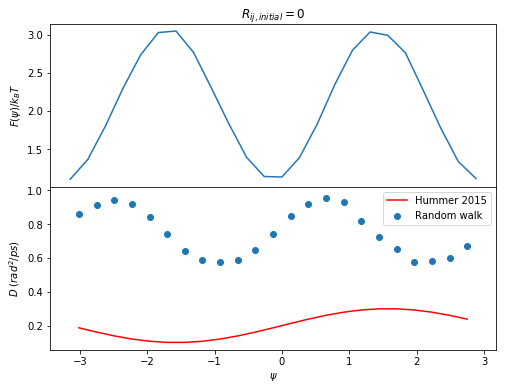

In [22]:
R, P, log_likelihood_array = MetropolisMC(Rij=10, Nij=Nij, P_method=calc_state_prob_from_data, rw_method=calc_param_matrix, dr=0.05, iterations=iterations, burnout=burnout)
plot_all(R, log_likelihood_array, 1, n, P, dpsi)

#### d. $R_{ij} = 100$
Random walk only on adjacent state transition indices.

Finished  0  of  10000  iterations...
Finished  1000  of  10000  iterations...
Finished  2000  of  10000  iterations...
Finished  3000  of  10000  iterations...
Finished  4000  of  10000  iterations...
Finished  5000  of  10000  iterations...
Finished  6000  of  10000  iterations...
Finished  7000  of  10000  iterations...
Finished  8000  of  10000  iterations...
Finished  9000  of  10000  iterations...


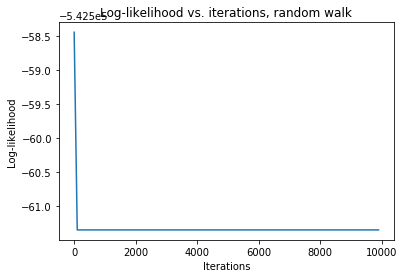

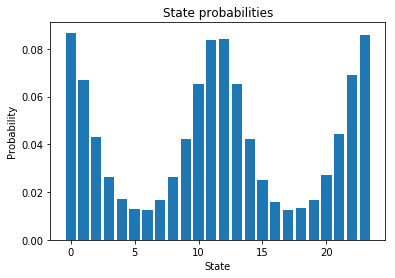

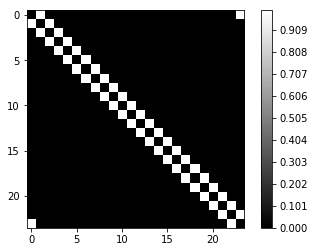

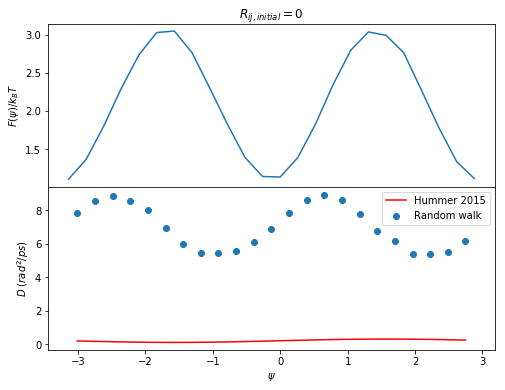

In [23]:
R, P, log_likelihood_array = MetropolisMC(Rij=100, Nij=Nij, P_method=calc_state_prob_from_data, rw_method=calc_param_matrix, dr=0.05, iterations=iterations, burnout=burnout)
plot_all(R, log_likelihood_array, 1, n, P, dpsi)

#### We look at the rate parameters, diffusion, and free energy where we initialize the rate parameters to be 0, 1, 10, and 100 allowing random walks **on all indices in the lower triangle**.

#### e. $R_{ij} = 0$
Random walk on all lower triangle indices.

Finished  0  of  10000  iterations...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp


Finished  1000  of  10000  iterations...
Finished  2000  of  10000  iterations...
Finished  3000  of  10000  iterations...
Finished  4000  of  10000  iterations...
Finished  5000  of  10000  iterations...
Finished  6000  of  10000  iterations...
Finished  7000  of  10000  iterations...
Finished  8000  of  10000  iterations...
Finished  9000  of  10000  iterations...


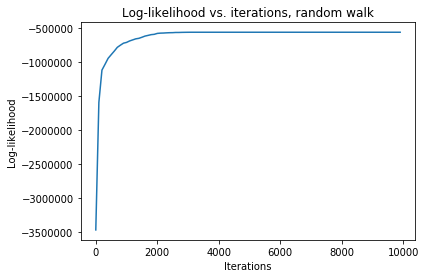

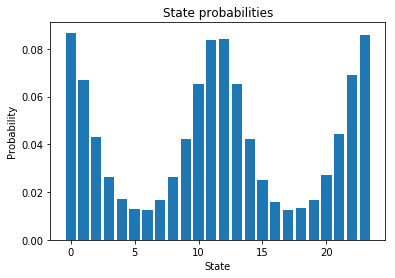

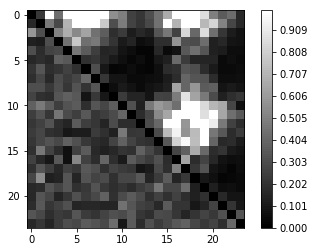

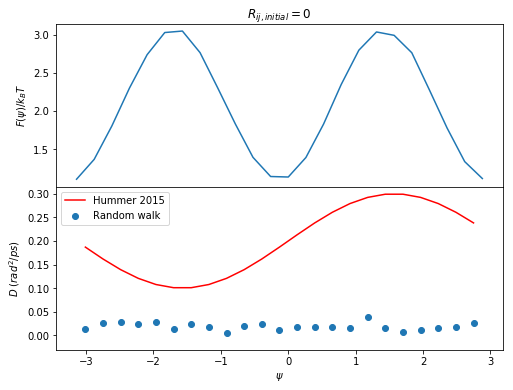

In [24]:
R, P, log_likelihood_array = MetropolisMC(Rij=0, Nij=Nij, P_method=calc_state_prob_from_data, rw_method=calc_param_matrix_all, dr=0.05, iterations=iterations, burnout=burnout)
plot_all(R, log_likelihood_array, 1, n, P, dpsi)

#### f. $R_{ij} = 1$
Random walk on all lower triangle indices.

Finished  0  of  10000  iterations...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp


Finished  1000  of  10000  iterations...
Finished  2000  of  10000  iterations...
Finished  3000  of  10000  iterations...
Finished  4000  of  10000  iterations...
Finished  5000  of  10000  iterations...
Finished  6000  of  10000  iterations...
Finished  7000  of  10000  iterations...
Finished  8000  of  10000  iterations...
Finished  9000  of  10000  iterations...


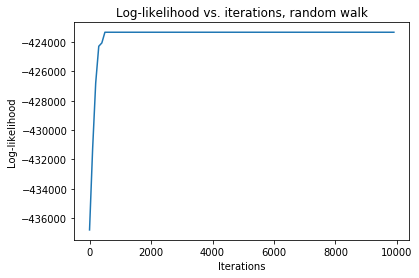

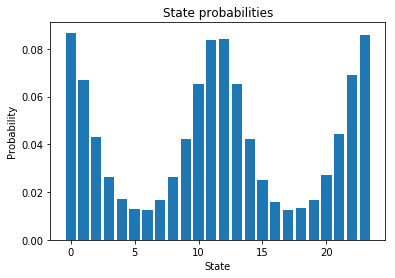

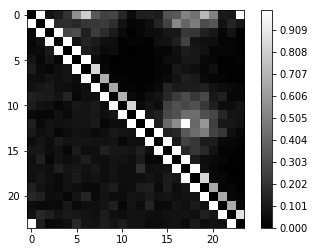

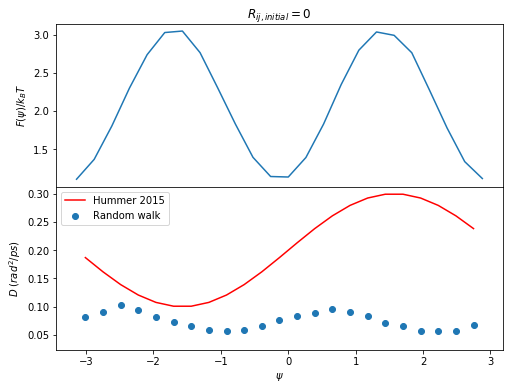

In [25]:
R, P, log_likelihood_array = MetropolisMC(Rij=1, Nij=Nij, P_method=calc_state_prob_from_data, rw_method=calc_param_matrix_all, dr=0.05, iterations=iterations, burnout=burnout)
plot_all(R, log_likelihood_array, 1, n, P, dpsi)

#### g. $R_{ij} = 10$
Random walk on all lower triangle indices.

Finished  0  of  10000  iterations...
Finished  1000  of  10000  iterations...
Finished  2000  of  10000  iterations...
Finished  3000  of  10000  iterations...
Finished  4000  of  10000  iterations...
Finished  5000  of  10000  iterations...
Finished  6000  of  10000  iterations...
Finished  7000  of  10000  iterations...
Finished  8000  of  10000  iterations...
Finished  9000  of  10000  iterations...


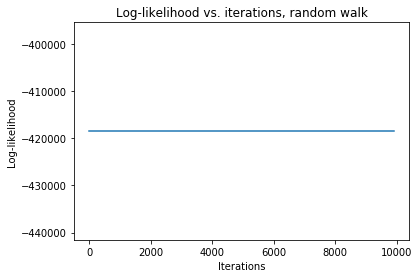

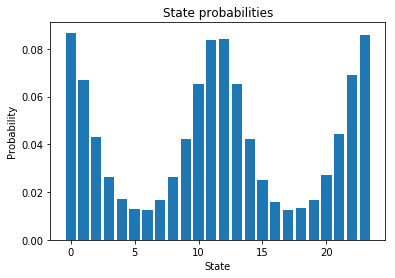

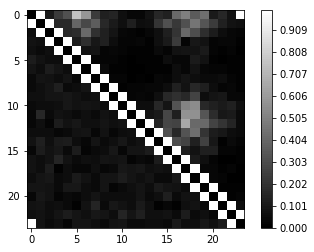

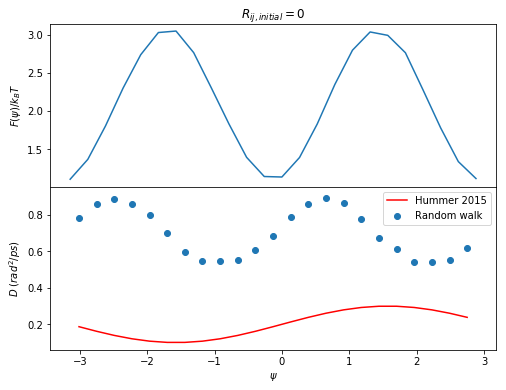

In [26]:
R, P, log_likelihood_array = MetropolisMC(Rij=10, Nij=Nij, P_method=calc_state_prob_from_data, rw_method=calc_param_matrix_all, dr=0.05, iterations=iterations, burnout=burnout)
plot_all(R, log_likelihood_array, 1, n, P, dpsi)

#### h. $R_{ij} = 100$
Random walk on all lower triangle indices.

Finished  0  of  10000  iterations...
Finished  1000  of  10000  iterations...
Finished  2000  of  10000  iterations...
Finished  3000  of  10000  iterations...
Finished  4000  of  10000  iterations...
Finished  5000  of  10000  iterations...
Finished  6000  of  10000  iterations...
Finished  7000  of  10000  iterations...
Finished  8000  of  10000  iterations...
Finished  9000  of  10000  iterations...


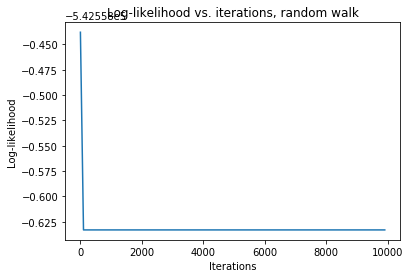

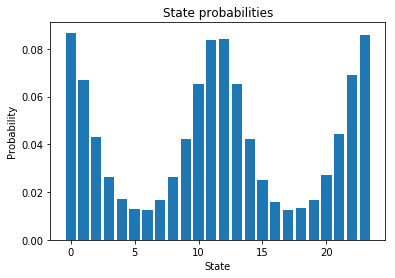

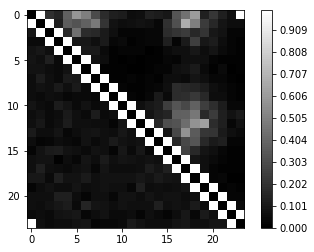

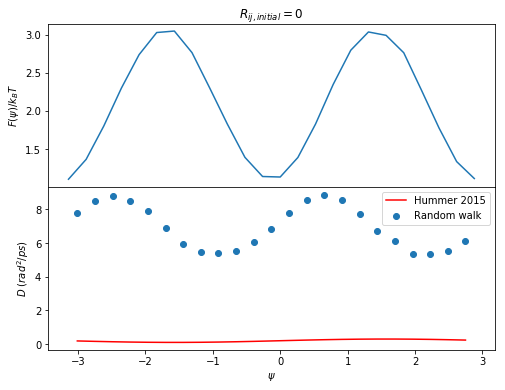

In [27]:
R, P, log_likelihood_array = MetropolisMC(Rij=100, Nij=Nij, P_method=calc_state_prob_from_data, rw_method=calc_param_matrix_all, dr=0.05, iterations=iterations, burnout=burnout)
plot_all(R, log_likelihood_array, 1, n, P, dpsi)

#### We then back-calculated the rate parameters from the diffusion coefficients in Hummer. It appeared that the rate parameters would hold values around 3-4, so we use both random walk procedures on initial rate parameters of 3 and 4.

#### i. $R_{ij} = 3$
Random walk only on adjacent state transition indices.

Finished  0  of  10000  iterations...
Finished  1000  of  10000  iterations...
Finished  2000  of  10000  iterations...
Finished  3000  of  10000  iterations...
Finished  4000  of  10000  iterations...
Finished  5000  of  10000  iterations...
Finished  6000  of  10000  iterations...
Finished  7000  of  10000  iterations...
Finished  8000  of  10000  iterations...
Finished  9000  of  10000  iterations...


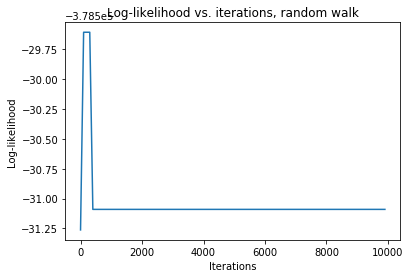

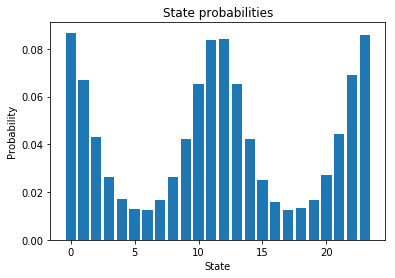

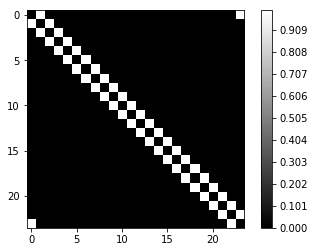

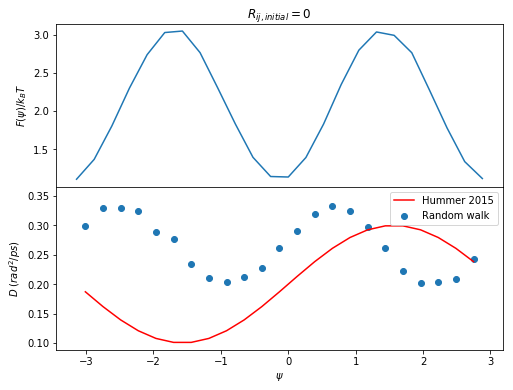

In [28]:
R, P, log_likelihood_array = MetropolisMC(Rij=3, Nij=Nij, P_method=calc_state_prob_from_data, rw_method=calc_param_matrix, dr=0.05, iterations=iterations, burnout=burnout)
plot_all(R, log_likelihood_array, 1, n, P, dpsi)

#### j. $R_{ij} = 4$
Random walk only on adjacent state transition indices.

Finished  0  of  10000  iterations...
Finished  1000  of  10000  iterations...
Finished  2000  of  10000  iterations...
Finished  3000  of  10000  iterations...
Finished  4000  of  10000  iterations...
Finished  5000  of  10000  iterations...
Finished  6000  of  10000  iterations...
Finished  7000  of  10000  iterations...
Finished  8000  of  10000  iterations...
Finished  9000  of  10000  iterations...


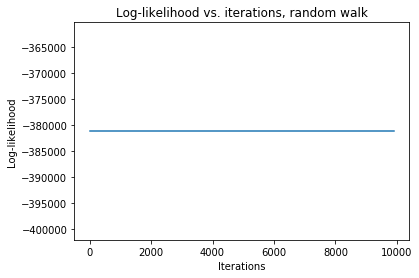

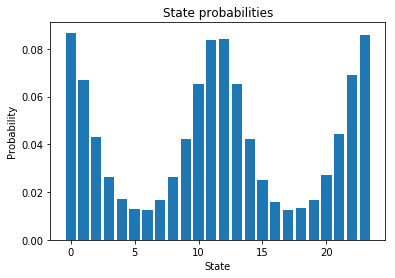

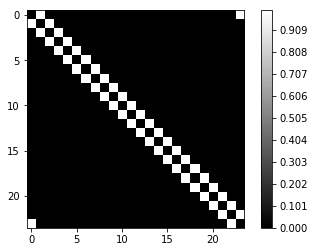

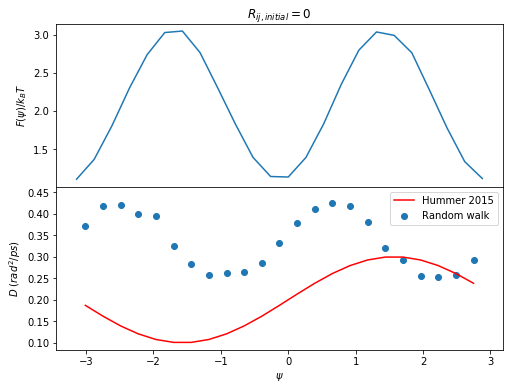

In [29]:
R, P, log_likelihood_array = MetropolisMC(Rij=4, Nij=Nij, P_method=calc_state_prob_from_data, rw_method=calc_param_matrix, dr=0.05, iterations=iterations, burnout=burnout)
plot_all(R, log_likelihood_array, 1, n, P, dpsi)

#### k. $R_{ij} = 3$
Random walk on all lower triangle indices.

Finished  0  of  10000  iterations...
Finished  1000  of  10000  iterations...
Finished  2000  of  10000  iterations...
Finished  3000  of  10000  iterations...
Finished  4000  of  10000  iterations...
Finished  5000  of  10000  iterations...
Finished  6000  of  10000  iterations...
Finished  7000  of  10000  iterations...
Finished  8000  of  10000  iterations...
Finished  9000  of  10000  iterations...


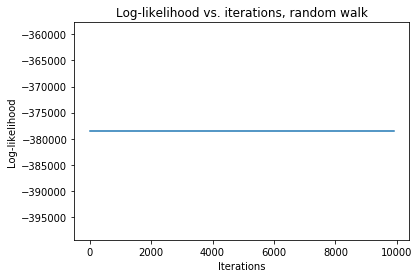

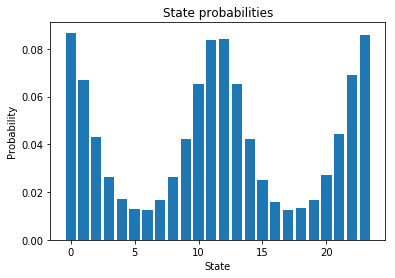

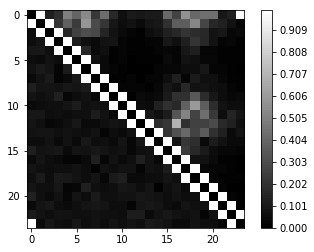

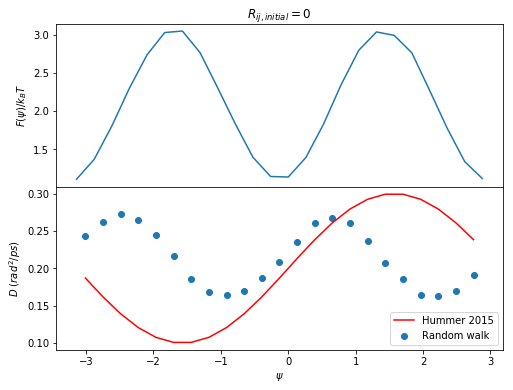

In [30]:
R, P, log_likelihood_array = MetropolisMC(Rij=3, Nij=Nij, P_method=calc_state_prob_from_data, rw_method=calc_param_matrix_all, dr=0.05, iterations=iterations, burnout=burnout)
plot_all(R, log_likelihood_array, 1, n, P, dpsi)

#### l. $R_{ij} = 4$
Random walk on all lower triangle indices.

Finished  0  of  10000  iterations...
Finished  1000  of  10000  iterations...
Finished  2000  of  10000  iterations...
Finished  3000  of  10000  iterations...
Finished  4000  of  10000  iterations...
Finished  5000  of  10000  iterations...
Finished  6000  of  10000  iterations...
Finished  7000  of  10000  iterations...
Finished  8000  of  10000  iterations...
Finished  9000  of  10000  iterations...


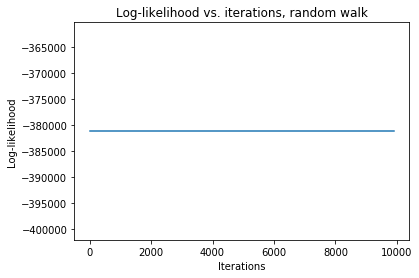

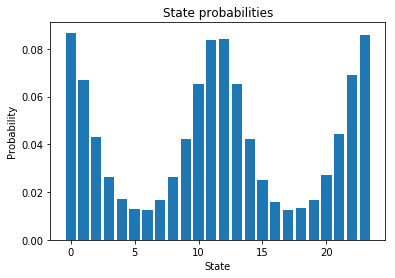

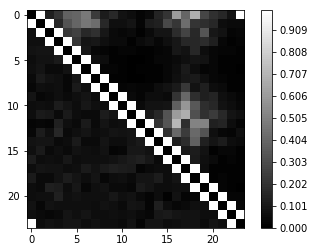

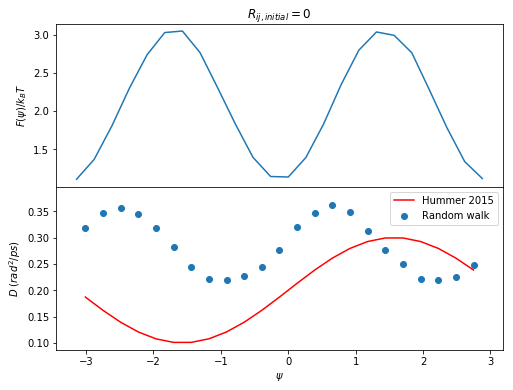

In [31]:
R, P, log_likelihood_array = MetropolisMC(Rij=4, Nij=Nij, P_method=calc_state_prob_from_data, rw_method=calc_param_matrix_all, dr=0.05, iterations=iterations, burnout=burnout)
plot_all(R, log_likelihood_array, 1, n, P, dpsi)